## Importing liberaries

In [1]:
import optuna
# import wandb
import logging
import sys
import os
import tensorflow as tf
import json
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, Dense, LSTM, Dropout, Bidirectional, MaxPooling1D, GlobalAveragePooling1D, AdditiveAttention, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import AdditiveAttention, Concatenate, BatchNormalization, Activation, MultiHeadAttention, LayerNormalization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, Callback

## Loading the data

In [2]:
url_data = 'https://raw.githubusercontent.com/TeodorRusKvi/Tekstanalyse/main/git_NLP_data/'

# Last inn 'y_train_LSTM' fra en CSV-fil
y_df = pd.read_csv(url_data+'y_liberal.csv')
# Konverter hele DataFrame til et NumPy array
y = y_df.to_numpy()

# Last inn 'y_train_LSTM' fra en CSV-fil
embeddings_GloVe = pd.read_csv(url_data+'embeddings_glove.csv')
# Konverter hele DataFrame til et NumPy array
embeddings_GloVe = embeddings_GloVe.to_numpy()


In [3]:
# Last inn 'X_train_LSTM' fra en CSV-fil
X_df = pd.read_csv(url_data+'X_text.csv')
# Konverter hele DataFrame til et NumPy array
X = X_df.to_numpy().flatten()

In [4]:
all_texts_length = X_df['Processed'].apply(lambda x: len(x.split()))
# Now, let's analyze the distribution of these sequence lengths
all_texts_length.describe()

count    12854.000000
mean        23.089311
std         86.574861
min          1.000000
25%          5.000000
50%          8.000000
75%         13.000000
max       2292.000000
Name: Processed, dtype: float64

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(oov_token='<OOV>') # Hyperparameters = num_words=vocab_size, oov_token=oov_tok
tokenizer.fit_on_texts(X)

#Creating a word index of the words from the tokenizer 
word_index = tokenizer.word_index
print(f'Found {len(word_index)} unique tokens.\n\nFirst 10 is listen below:')
print(dict(list(word_index.items())[0:10]))

Found 22234 unique tokens.

First 10 is listen below:
{'<OOV>': 1, 'people': 2, 'like': 3, 'work': 4, 'right': 5, 'trump': 6, 'think': 7, 'state': 8, 'government': 9, 'party': 10}


In [6]:
# Defining pre-processing hyperparameters for the networks
max_len = 100
trunc_type = "post"
padding_type = "post"
vocab_size = len(word_index)
# This is fixed.
embedding_dim = 100
EPOCHS=20
BATCH_SIZE = 32
num_classes = 1

In [7]:
# Encoding the sequences from the reddit posts
X = tokenizer.texts_to_sequences(X)
# Padding the sequences to keep the lengths uniform
X = pad_sequences(X, maxlen=max_len, padding=padding_type, truncating=trunc_type)
# print('Shape of data tensor:', X_tensorflow.shape)

In [8]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

In [9]:
# Loading the params from CNN-LSTM from the saved JSON-fil
with open(r'C:\Users\bugat\Prosjekter\Tekstanalyse\git_NLP\Tekstanalyse\git_NLP_Notebooks\Hypertuning_trials\best_trial_1.json', 'r') as f:
    data = json.load(f)
    params = data['params']

## The LSTM-CNN model with tuned hyperparameters and attention layer

In [10]:
# # extracting the parameters
# lstm_units = params['lstm_units']
# dense_1_units = params['dense_1_units']
# dense_2_units = params['dense_2_units']
# dropout_rate = params['dropout_rate']
# learning_rate = params['learning_rate']

In [11]:
class ModelConfig:
    def __init__(self, max_len, num_classes, embeddings_GloVe):
        self.max_len = max_len
        self.num_classes = num_classes
        self.embeddings_GloVe = embeddings_GloVe


# Create a configuration object
config = ModelConfig(max_len=max_len, num_classes=num_classes, embeddings_GloVe=embeddings_GloVe)

In [12]:
def CNN_LSTM_sequential(params, config):
    input_layer = Input(shape=(config.max_len,), dtype='int32')
    
    # Use config object for fixed parameters such as embeddings
    embedding = Embedding(input_dim=config.embeddings_GloVe.shape[0],
                          output_dim=config.embeddings_GloVe.shape[1],
                          weights=[config.embeddings_GloVe],
                          trainable=False)(input_layer)
    
    # Use params dictionary for dynamic hyperparameters
    dropout = Dropout(params['dropout_rate'])(embedding)

    conv = Conv1D(filters=params['conv_filters'], kernel_size=1, activation='relu')(dropout)
    conv = BatchNormalization()(conv)

    lstm = Bidirectional(LSTM(params['lstm_units'], return_sequences=True, dropout=params['lstm_dropout'], recurrent_dropout=params['lstm_recurrent']))(conv)
    lstm = LayerNormalization()(lstm)
    
    num_heads = params['heads']
    attention_layer = MultiHeadAttention(num_heads=num_heads, key_dim=config.embeddings_GloVe.shape[1] // num_heads, dropout=0.1)
    attention_output = attention_layer(query=lstm, key=lstm, value=lstm)
    attention_output = LayerNormalization()(attention_output)

    dense = Dense(params['dense_2_units'], activation='relu')(attention_output)
    dense = BatchNormalization()(dense)
    output = Dense(config.num_classes, activation='sigmoid')(dense)
    
    model = Model(inputs=input_layer, outputs=output)
    model.compile(loss='binary_crossentropy', optimizer=Adam(params['learning_rate']), metrics=['accuracy'])
    
    return model

In [14]:
import sys
import logging
import optuna
from tensorflow.keras.callbacks import EarlyStopping
from optuna.integration import KerasPruningCallback
import optuna_dashboard
import os


# Define the objective function including the logging of each trial's outcome
def objective(trial):
    # wandb.init(project="optuna_with_wandb", entity="your_entity_here", reinit=True)
    params = {
        'lstm_units': trial.suggest_int('lstm_units', 100, 150, step=5),
        'dense_1_units': trial.suggest_int('dense_1_units', 100, 150, step=5),
        'dense_2_units': trial.suggest_int('dense_2_units', 100, 150, step=5),
        'dropout_rate': trial.suggest_float('dropout_rate', 0.2, 0.5),
        'lstm_dropout': trial.suggest_float('lstm_dropout', 0.0, 0.2),
        'lstm_recurrent': trial.suggest_float('lstm_recurrent', 0.0, 0.2),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True),
        'conv_filters': trial.suggest_int('conv_filters', 32, 64, step=2),
        'heads': trial.suggest_int('heads', 8, 16, step=8)
    }

    # # Log hyperparameters to wandb
    # wandb.config.update(params)

    # Build and train the model
    model = CNN_LSTM_sequential(params, config)

    #Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    pruning_callback = KerasPruningCallback(trial, 'val_loss')  # Create a pruning callback
    # Fit the model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10,
                        callbacks=[early_stopping, pruning_callback], batch_size=32, verbose=1)

    # Evaluate the model
    loss, accuracy = model.evaluate(X_val, y_val, verbose=1)
    
    # Log final metrics to wandb
    # wandb.log({"loss": loss, "accuracy": accuracy})

    # Ensure wandb run is finished after each trial
    # wandb.finish()
    
    # trial.report(accuracy, 1)  # Report the accuracy to Optuna
    return accuracy 


# Setup Optuna with persistent storage
storage_url = "sqlite:///db.sqlite3"
study_name = 'new_study'
# optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
study = optuna.create_study(direction='maximize', 
                            sampler=optuna.samplers.TPESampler(), 
                            study_name=study_name, 
                            storage=storage_url, 
                            pruner=optuna.pruners.MedianPruner(),  # Adding a pruner
                            load_if_exists=True)

study.optimize(objective, n_trials=100)
print(f"Best value: {study.best_value} (params: {study.best_params})")

[I 2024-04-28 20:23:25,234] A new study created in RDB with name: new_study


Epoch 1/10
282/282 [==============================] - 203s 635ms/step - loss: 0.6766 - accuracy: 0.6029 - val_loss: 1.4086 - val_accuracy: 0.3757
Epoch 2/10
282/282 [==============================] - 166s 589ms/step - loss: 0.6390 - accuracy: 0.6465 - val_loss: 0.6290 - val_accuracy: 0.6707
Epoch 3/10
282/282 [==============================] - 182s 645ms/step - loss: 0.6216 - accuracy: 0.6633 - val_loss: 0.6728 - val_accuracy: 0.6607
Epoch 4/10
282/282 [==============================] - 175s 621ms/step - loss: 0.6110 - accuracy: 0.6672 - val_loss: 0.6291 - val_accuracy: 0.6793
Epoch 5/10
61/61 [==============================] - 9s 145ms/step - loss: 0.6290 - accuracy: 0.6707


[I 2024-04-28 20:38:35,255] Trial 0 finished with value: 0.6706638932228088 and parameters: {'lstm_units': 145, 'dense_1_units': 100, 'dense_2_units': 145, 'dropout_rate': 0.49150811984369386, 'lstm_dropout': 0.05185497035334492, 'lstm_recurrent': 0.045681101612680464, 'learning_rate': 0.00012456053789046276, 'conv_filters': 64, 'heads': 13}. Best is trial 0 with value: 0.6706638932228088.


Epoch 1/10
282/282 [==============================] - 108s 345ms/step - loss: 0.6321 - accuracy: 0.6567 - val_loss: 0.6504 - val_accuracy: 0.6735
Epoch 2/10
282/282 [==============================] - 58s 205ms/step - loss: 0.5874 - accuracy: 0.6963 - val_loss: 0.6110 - val_accuracy: 0.6912
Epoch 3/10
282/282 [==============================] - 57s 204ms/step - loss: 0.5580 - accuracy: 0.7160 - val_loss: 0.5515 - val_accuracy: 0.7256
Epoch 4/10
282/282 [==============================] - 75s 265ms/step - loss: 0.5434 - accuracy: 0.7269 - val_loss: 0.5196 - val_accuracy: 0.7469
Epoch 5/10
282/282 [==============================] - 81s 287ms/step - loss: 0.5321 - accuracy: 0.7402 - val_loss: 0.5171 - val_accuracy: 0.7509
Epoch 6/10
 85/282 [========>.....................] - ETA: 52s - loss: 0.5184 - accuracy: 0.7471

In [ ]:
def objective(trial):
    params = {
        'lstm_units': trial.suggest_int('lstm_units', 100, 150),
        'dense_1_units': trial.suggest_int('dense_1_units', 100, 150),
        'dense_2_units': trial.suggest_int('dense_2_units', 100, 150),
        'dropout_rate': trial.suggest_float('dropout_rate', 0.2, 0.5),
        'lstm_dropout': trial.suggest_float('lstm_dropout', 0.0, 0.2),
        'lstm_recurrent': trial.suggest_float('lstm_recurrent', 0.0, 0.2),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True),
        'conv_filters': trial.suggest_int('conv_filters', 32, 64),
        'heads': trial.suggest_int('heads', 8, 16)
    }
    model = CNN_LSTM_sequential(params, config)
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    # Fit the model
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20,
              callbacks=[early_stopping], batch_size=32, verbose=0)

    # Evaluate the model
    loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
    trial.report(accuracy, 1)  # Report the accuracy to Optuna

    # Handle pruning based on the intermediate value.
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
    
    print(f'Trial {trial.number} completed - Loss: {loss}, Accuracy: {accuracy}')
    return loss  # Return the loss to minimize

# Add stream handler of stdout to show the messages
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))


def create_study():

     # Define a callback to stop the study early if trials are continuously pruned
    class StopWhenTrialKeepBeingPrunedCallback:
        def __init__(self, patience):
            self.patience = patience
            self._pruned_trials = 0

        def __call__(self, study, trial):
            if trial.state == optuna.trial.TrialState.PRUNED:
                self._pruned_trials += 1
            else:
                self._pruned_trials = 0

            if self._pruned_trials >= self.patience:
                study.stop()

    # Add stream handler of stdout to show the messages
    optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
    study_stop_cb = StopWhenTrialKeepBeingPrunedCallback(2)
    pruner = optuna.pruners.MedianPruner()
    study = optuna.create_study(direction='minimize', pruner=pruner)
    study.optimize(objective, n_trials=50, callbacks=[study_stop_cb])

    print('Best hyperparameters:', study.best_trial.params)

# if __name__ == '__main__':
#     create_study()

[I 2024-04-26 13:49:21,509] A new study created in memory with name: no-name-3f247e1f-de76-402f-a4b8-aefa4ab3c903


A new study created in memory with name: no-name-3f247e1f-de76-402f-a4b8-aefa4ab3c903
A new study created in memory with name: no-name-3f247e1f-de76-402f-a4b8-aefa4ab3c903
A new study created in memory with name: no-name-3f247e1f-de76-402f-a4b8-aefa4ab3c903
A new study created in memory with name: no-name-3f247e1f-de76-402f-a4b8-aefa4ab3c903
A new study created in memory with name: no-name-3f247e1f-de76-402f-a4b8-aefa4ab3c903
A new study created in memory with name: no-name-3f247e1f-de76-402f-a4b8-aefa4ab3c903
A new study created in memory with name: no-name-3f247e1f-de76-402f-a4b8-aefa4ab3c903
A new study created in memory with name: no-name-3f247e1f-de76-402f-a4b8-aefa4ab3c903
A new study created in memory with name: no-name-3f247e1f-de76-402f-a4b8-aefa4ab3c903


[W 2024-04-26 13:49:36,652] Trial 0 failed with parameters: {'lstm_units': 117, 'dense_1_units': 119, 'dense_2_units': 133, 'dropout_rate': 0.2598136136556385, 'lstm_dropout': 0.1245546333497069, 'lstm_recurrent': 0.08670736311217181, 'learning_rate': 0.005686886792368319, 'conv_filters': 42, 'heads': 14} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\bugat\anaconda3\Lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\bugat\AppData\Local\Temp\ipykernel_35072\2680062479.py", line 17, in objective
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20,
  File "c:\Users\bugat\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\bugat\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 

Trial 0 failed with parameters: {'lstm_units': 117, 'dense_1_units': 119, 'dense_2_units': 133, 'dropout_rate': 0.2598136136556385, 'lstm_dropout': 0.1245546333497069, 'lstm_recurrent': 0.08670736311217181, 'learning_rate': 0.005686886792368319, 'conv_filters': 42, 'heads': 14} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\bugat\anaconda3\Lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\bugat\AppData\Local\Temp\ipykernel_35072\2680062479.py", line 17, in objective
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20,
  File "c:\Users\bugat\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\bugat\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1807, in fit
    tmp_logs = 

[W 2024-04-26 13:49:36,704] Trial 0 failed with value None.


Trial 0 failed with value None.
Trial 0 failed with value None.
Trial 0 failed with value None.
Trial 0 failed with value None.
Trial 0 failed with value None.
Trial 0 failed with value None.
Trial 0 failed with value None.
Trial 0 failed with value None.
Trial 0 failed with value None.


In [ ]:

# class OptunaCallback(Callback):
#     """ Custom callback for Optuna to report intermediate results and handle pruning. """
#     def __init__(self, trial, prune=False):
#         super().__init__()
#         self.trial = trial
#         self.prune = prune

#     def on_epoch_end(self, epoch, logs=None):
#         logs = logs or {}
#         val_loss = logs.get('val_loss')
#         self.trial.report(val_loss, epoch)
#         if self.prune and self.trial.should_prune():
#             raise optuna.exceptions.TrialPruned()

# def objective(trial):
#     with wandb.init(project='optuna_with_wandb', entity='teodor-ruskvi'):
#         params = {
#             'lstm_units': trial.suggest_int('lstm_units', 100, 150),
#             'dense_1_units': trial.suggest_int('dense_1_units', 100, 150),
#             'dense_2_units': trial.suggest_int('dense_2_units', 100, 150),
#             'dropout_rate': trial.suggest_float('dropout_rate', 0.2, 0.5),
#             'heads': trial.suggest_int('heads', 8, 16),
#             'lstm_dropout': trial.suggest_float('lstm_dropout', 0.0, 0.2),
#             'lstm_recurrent': trial.suggest_float('lstm_recurrent', 0.0, 0.2),
#             'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-2),
#             'conv_filters': trial.suggest_int('conv_filters', 32, 64)  # Corrected range for convolutional filters
#         }
#         wandb.config.update(params)

#         model = CNN_LSTM_sequential(
#             max_len=max_len,
#             dropout_rate=params['dropout_rate'],
#             conv_filters=params['conv_filters'],
#             lstm_units=params['lstm_units'],
#             lstm_dropout=params['lstm_dropout'],
#             lstm_recurrent=params['lstm_recurrent'],
#             heads=params['heads'],
#             dense_2_units=params['dense_2_units'],
#             learning_rate=params['learning_rate'],
#             num_classes=1,
#             embeddings_GloVe=embeddings_GloVe
#         )

#         early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
#         optuna_callback = OptunaCallback(trial, prune=True)
#         model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, callbacks=[early_stopping, optuna_callback], batch_size=32, verbose=0)

#         loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
#         wandb.log({'val_loss': loss, 'val_accuracy': accuracy})
#         return loss

# def create_study():
#     pruner = optuna.pruners.MedianPruner()
#     study = optuna.create_study(direction='minimize', pruner=pruner)
#     study.optimize(objective, n_trials=50)

#     print('Best hyperparameters:', study.best_trial.params)

# if __name__ == '__main__':
#     create_study()

In [ ]:
# num_classes = 1
# EPOCHS=20
# BATCH_SIZE = 32

# model = CNN_LSTM_sequential(max_len, lstm_units, dense_1_units, dense_2_units, dropout_rate, learning_rate, num_classes, embeddings_GloVe)

# early_stopping_callback = EarlyStopping(monitor='val_loss', patience=4, min_delta=0.0000001)


# history = model.fit(X_train, y_train,
#                     epochs=20,
#                     validation_data=(X_val, y_val),
#                     batch_size=BATCH_SIZE,
#                     callbacks=early_stopping_callback
#                     )

Epoch 1/20
282/282 [==============================] - 45s 112ms/step - loss: 0.6178 - accuracy: 0.6671 - val_loss: 0.5766 - val_accuracy: 0.6955
Epoch 2/20
282/282 [==============================] - 31s 111ms/step - loss: 0.5788 - accuracy: 0.6984 - val_loss: 0.5599 - val_accuracy: 0.7183
Epoch 3/20
282/282 [==============================] - 32s 115ms/step - loss: 0.5609 - accuracy: 0.7177 - val_loss: 0.5644 - val_accuracy: 0.7221
Epoch 4/20
282/282 [==============================] - 31s 110ms/step - loss: 0.5526 - accuracy: 0.7244 - val_loss: 0.5259 - val_accuracy: 0.7560
Epoch 5/20
282/282 [==============================] - 35s 126ms/step - loss: 0.5359 - accuracy: 0.7375 - val_loss: 0.5436 - val_accuracy: 0.7468
Epoch 6/20
282/282 [==============================] - 36s 127ms/step - loss: 0.5376 - accuracy: 0.7291 - val_loss: 0.5447 - val_accuracy: 0.7401
Epoch 7/20
282/282 [==============================] - 33s 119ms/step - loss: 0.5347 - accuracy: 0.7373 - val_loss: 0.5381 - val_ac

In [ ]:
model.summary()

Model: "model_45"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_50 (InputLayer)       [(None, 100)]                0         []                            
                                                                                                  
 embedding_49 (Embedding)    (None, 100, 100)             2223500   ['input_50[0][0]']            
                                                                                                  
 dropout_67 (Dropout)        (None, 100, 100)             0         ['embedding_49[0][0]']        
                                                                                                  
 conv1d_46 (Conv1D)          (None, 100, 64)              6464      ['dropout_67[0][0]']          
                                                                                           

## Evaluation of the model

61/61 [==============================] - 2s 39ms/step - loss: 0.6458 - accuracy: 0.6085
Test Loss: 0.6458245515823364
Test Accuracy: 0.6085380911827087


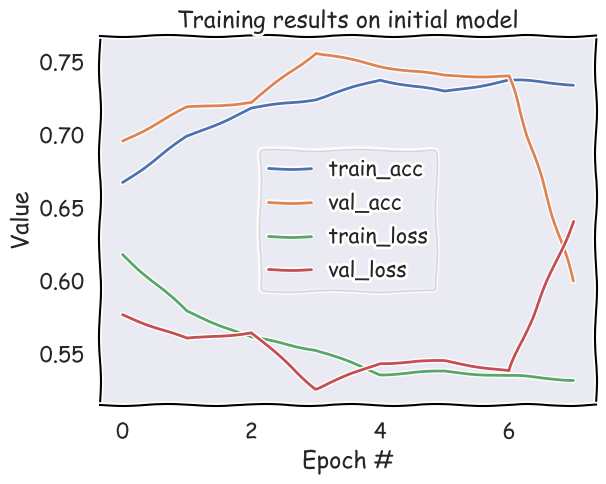

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

import logging
logging.getLogger('matplotlib.font_manager').disabled = True

with plt.xkcd():
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')



    plt.xlabel('Epoch #')
    plt.ylabel('Value')
    plt.title('Training results on initial model')
    plt.legend()

    plt.show()

## Classification metrics

31/31 [==============================] - 3s 56ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.83      0.62       681
           1       0.85      0.54      0.66      1248

    accuracy                           0.64      1929
   macro avg       0.67      0.68      0.64      1929
weighted avg       0.72      0.64      0.65      1929

Accuracy: 0.6402280974598238
Recall: 0.5392628205128205
Precision: 0.8497474747474747
F1 Score: 0.6598039215686274


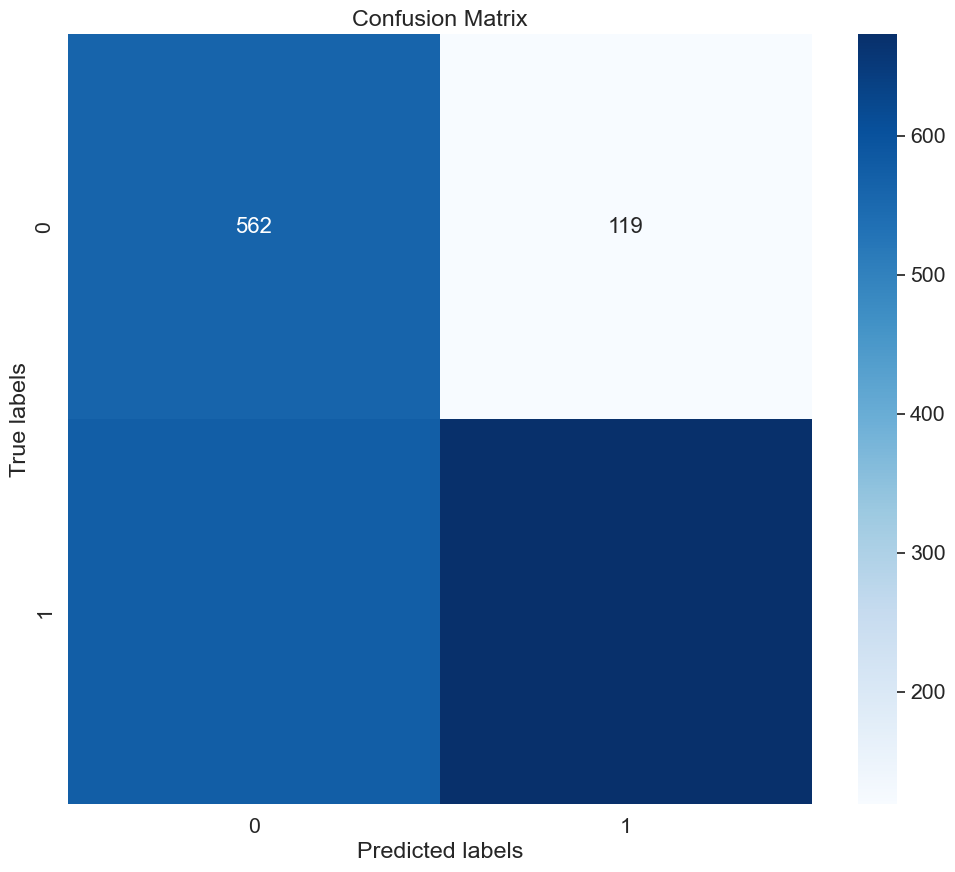

In [ ]:
# Predict probabilities for the positive class (class 1)
probabilities = model.predict(X_test, batch_size=64)

# Ensure that probabilities are in the expected format
# y_pred = (probabilities > 0.5).astype(int).flatten()
y_pred = (probabilities[:, 0] > 0.5).astype(int)  # Indexing the first column if necessary


# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Calculating different metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print each metric
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1 Score:", f1)

# Creating a confusion matrix for visualization
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(12,10))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues')  # fmt='g' to avoid scientific notation

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()